# Set up

In [1]:
library(FactoMineR)
library(tidyverse)
library(ComplexHeatmap)
library(ggpubr)
library(iClusterPlus)
library(tsne)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.


Loading required package: magrittr


Attaching pa

In [2]:
# Specify path to directory with downloaded data
data_dir_path = "aml"
stopifnot(file.exists(file.path(data_dir_path, 'exp_tr')) & file.exists(file.path(data_dir_path, 'methy')) & 
          file.exists(file.path(data_dir_path, 'mirna_tr')))

In [3]:
# Inrease plot resolution in this notebook
options(repr.plot.res=200)

In [5]:
# Load data. See previous notebook for details
data_exp <- read.table(file.path(data_dir_path, 'exp_tr'))
data_met <- read.table(file.path(data_dir_path, 'methy'))
data_mirna <- read.table(file.path(data_dir_path, 'mirna_tr'))
c(dim(data_exp), dim(data_met), dim(data_mirna))
subtypes <- read_tsv("TCGA_subtypes/AML_subtypes.tsv", show_col_types = FALSE)

[1] 19940   173  5000   194   561   188

In [6]:
# set color palettes we are going to use for subtype visualization
exp_subtypes_col = setNames(RColorBrewer::brewer.pal(name = "Set2", n = 7),
                            unique(na.omit(subtypes$Subtype_Selected)))
miRNA_subtypes_col = setNames(RColorBrewer::brewer.pal(name = "Set2", n = 5),
                            unique(na.omit(subtypes$Subtype_miRNA)))

# Multi-omics data integration for unsupervised mulit-omics data integration

<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/nar/46/20/10.1093_nar_gky889/2/gky889fig1.jpeg?Expires=1633918613&Signature=q7-xAd3hPRo9y1glQYoRXxTYCIt0DaEJOztZag7fqnR0wOjlsCf30QUYE01BJjDJhf2TSbZmr7aameK1nU6tFUeu8w95JdosG~uJCRR75bJ35creQdclLhyfdw7nHs~bGKxVvGl3rQj57RaSy~bVNQfivyW8jjIhSFdV03kknEZ2DQUR5BZorZm2rYVa1Q4nxvfgg73krITuWOM0kMvcUg6rOg-vyl-GSfTsyGFrGPYpdouojlmwyWh7Hf3dp2khTor1xaKxE1FHem7xPst7-JHjcExl2etiBhmXN-wSrGR3SAb~LYfE-8mBeX-Eal9K3F6NEv8uTbIxhglZ6AEp1g__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA">

    Figure Source: Rappoport, N., & Shamir, R. (2018). Multi-omic and multi-view clustering algorithms: review and cancer benchmark. Nucleic Acids Research, 46(20), 10546–10562. https://doi.org/10.1093/nar/gky889

In [7]:
bound_matrices <- plyr::rbind.fill(data_exp, data_met, data_mirna)
dim(bound_matrices)

[1] 25501   197

In [8]:
subtypes_data <- tibble(sample_codes=colnames(bound_matrices)) %>%  #in order of columns in bound_matrices
    left_join(subtypes, by = "sample_codes")  %>% 
    mutate(exp = sample_codes %in% colnames(data_exp),
           met = sample_codes %in% colnames(data_met),
           mirna = sample_codes %in% colnames(data_mirna))
head(subtypes_data)

sample_codes,samples,Subtype_miRNA,Subtype_mRNA,Subtype_Selected,exp,met,mirna
<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>
TCGA.AB.2803.03,TCGA-AB-2803,5,3,AML.3,TRUE,TRUE,TRUE
TCGA.AB.2805.03,TCGA-AB-2805,1,5,AML.5,TRUE,TRUE,TRUE
TCGA.AB.2806.03,TCGA-AB-2806,4,4,AML.4,TRUE,TRUE,TRUE
TCGA.AB.2807.03,TCGA-AB-2807,4,6,AML.6,TRUE,TRUE,TRUE
TCGA.AB.2808.03,TCGA-AB-2808,4,5,AML.5,TRUE,TRUE,TRUE
TCGA.AB.2810.03,TCGA-AB-2810,3,1,AML.1,TRUE,TRUE,TRUE


## Matrix Factorization methods

Matrix factorization techniques attempt to infer a set of latent variables from the data by finding factors of a data matrix. Principal Component Analysis (PCA) is a form of matrix factorization which finds factors based on the covariance structure of the data. Generally, matrix factorization methods may be formulated as:

**X = WH**,

where: 
- X is the data matrix \[M×N\], M is the number of features (for example genes)and N is the number of samples
- W is an \[M×K\] factor matrix, 
- H is the \[KxN\] latent variable coefficient matrix 

Tying this back to PCA, where  *X = UΣV^T*, we may formulate the factorization in the same terms by setting *W = UΣ* and *H = V^T*. If *K = rank(X)*, this factorization is *lossless*, i.e. *X=WH*. However, normally we seek a latent variable model with a considerably lower dimensionality than X (a low-rank representation of our data). In this case, we choose *K < rank(X)* and the factorization is *lossy*, i.e **X ≈ WH**. 

Thus, matrix factorization methods normally opt to minimize the error: **min ∥X − WH∥**.

The loss function we choose to minimize may be further subject to some constraints or regularization terms. In the context of latent factor models, a regularization term might be added to the loss function, i.e. we might choose to minimize **min ∥X − WH∥ + λ∥W∥^2** (so called L2-regularization), instead of merely the reconstruction error. Adding such a term to our loss function here will push the *W* matrix entries towards 0, in effect balancing between better reconstruction of the data and a more parsimonious model. A more parsimonious latent factor model is one with more sparsity in the latent factors, which is desirable for model interpretation.

## (1) Multiple Factor Analysis (MFA)

Multiple factor analysis is an example of early integration method and a straightforward extension of PCA into the domain of multiple data types. The figure below illustrates a naive extension of PCA to a multi-omics context, where data matrices from different platforms are concatenated, befor applying PCA. The PCA finds the linear combinations of the features which, when the data is projected onto them, preserve the most variance of any K-dimensional space. But because measurements from different experiments have different scales, they will also have variance (and co-variance) at different scales. Multiple Factor Analysis addresses this issue and achieves balance among the data types by **normalizing each of the data types** *X(i)* separately. Each feature matrix is divided by the first eigenvalue *λ_1* of the principal component decomposition of said matrix. After this normalization step, the matrices are "stacked" and passed on to PCA.

<img src="https://compgenomr.github.io/book/images/mfa.png">

In [9]:
# run the MFA function from the FactoMineR package (this may take a couple of minutes)
r.mfa <- MFA(
  t(bound_matrices), # binding the omics types together
  c(dim(data_exp)[1], dim(data_met)[1], dim(data_mirna)[1]), # specifying the dimensions of each omic
  graph=FALSE)

In [10]:
# first, extract the H and W matrices from the MFA run result
mfa.h <- r.mfa$global.pca$ind$coord
mfa.w <- r.mfa$quanti.var$coord

# create a dataframe with the H matrix and the CMS label
mfa_df <- as.data.frame(mfa.h)
mfa_df$subtype_miRNA <- factor(subtypes_data$Subtype_miRNA)
mfa_df$subtype_mRNA <- factor(subtypes_data$Subtype_Selected)

mfa_df %>% head()

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,subtype_miRNA,subtype_mRNA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
TCGA.AB.2803.03,0.2527631,-1.7862573,-3.81796632,-0.99349053,0.89195643,5,AML.3
TCGA.AB.2805.03,-0.1633910,1.0362848,1.64650406,-0.17931261,-0.73357725,1,AML.5
TCGA.AB.2806.03,1.0196146,1.7908275,0.01381809,-2.45432524,-1.08710842,4,AML.4
TCGA.AB.2807.03,2.0351645,0.3528843,1.48821003,-0.01699301,0.09485044,4,AML.6
TCGA.AB.2808.03,0.8601374,1.3019416,0.55507317,-1.63230868,-1.62069228,4,AML.5
TCGA.AB.2810.03,-0.4773419,1.2139515,-1.70745306,2.63844214,0.68582922,3,AML.1


Since this generates a 5-dimensional factorization of the multi-omics data, we will run tSNE to help with visualization and get the intuition of how the MFA factors separate the samples.

In [11]:
# We run tSNE to visually inspect sample separation by existing subtypes
mfa.h.tsne <- tsne(mfa.h)
mfa.h.tsne.tbl <- as_tibble(mfa.h.tsne) %>%
    rename(tSNE_1=V1, tSNE_2=V2) %>%
    mutate(sample_codes = rownames(mfa.h)) 

sigma summary: Min. : 0.415658909962982 |1st Qu. : 0.538223861612916 |Median : 0.587855264486558 |Mean : 0.59566562576262 |3rd Qu. : 0.637941969661125 |Max. : 0.885911269418172 |

Epoch: Iteration #100 error is: 14.3581528347841

Epoch: Iteration #200 error is: 0.510292021938236

Epoch: Iteration #300 error is: 0.441797043900085

Epoch: Iteration #400 error is: 0.430897325956132

Epoch: Iteration #500 error is: 0.430482125279325

Epoch: Iteration #600 error is: 0.430054440165787

Epoch: Iteration #700 error is: 0.42975185552439

Epoch: Iteration #800 error is: 0.429574229864896

Epoch: Iteration #900 error is: 0.429477886389354

Epoch: Iteration #1000 error is: 0.429424390288358

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


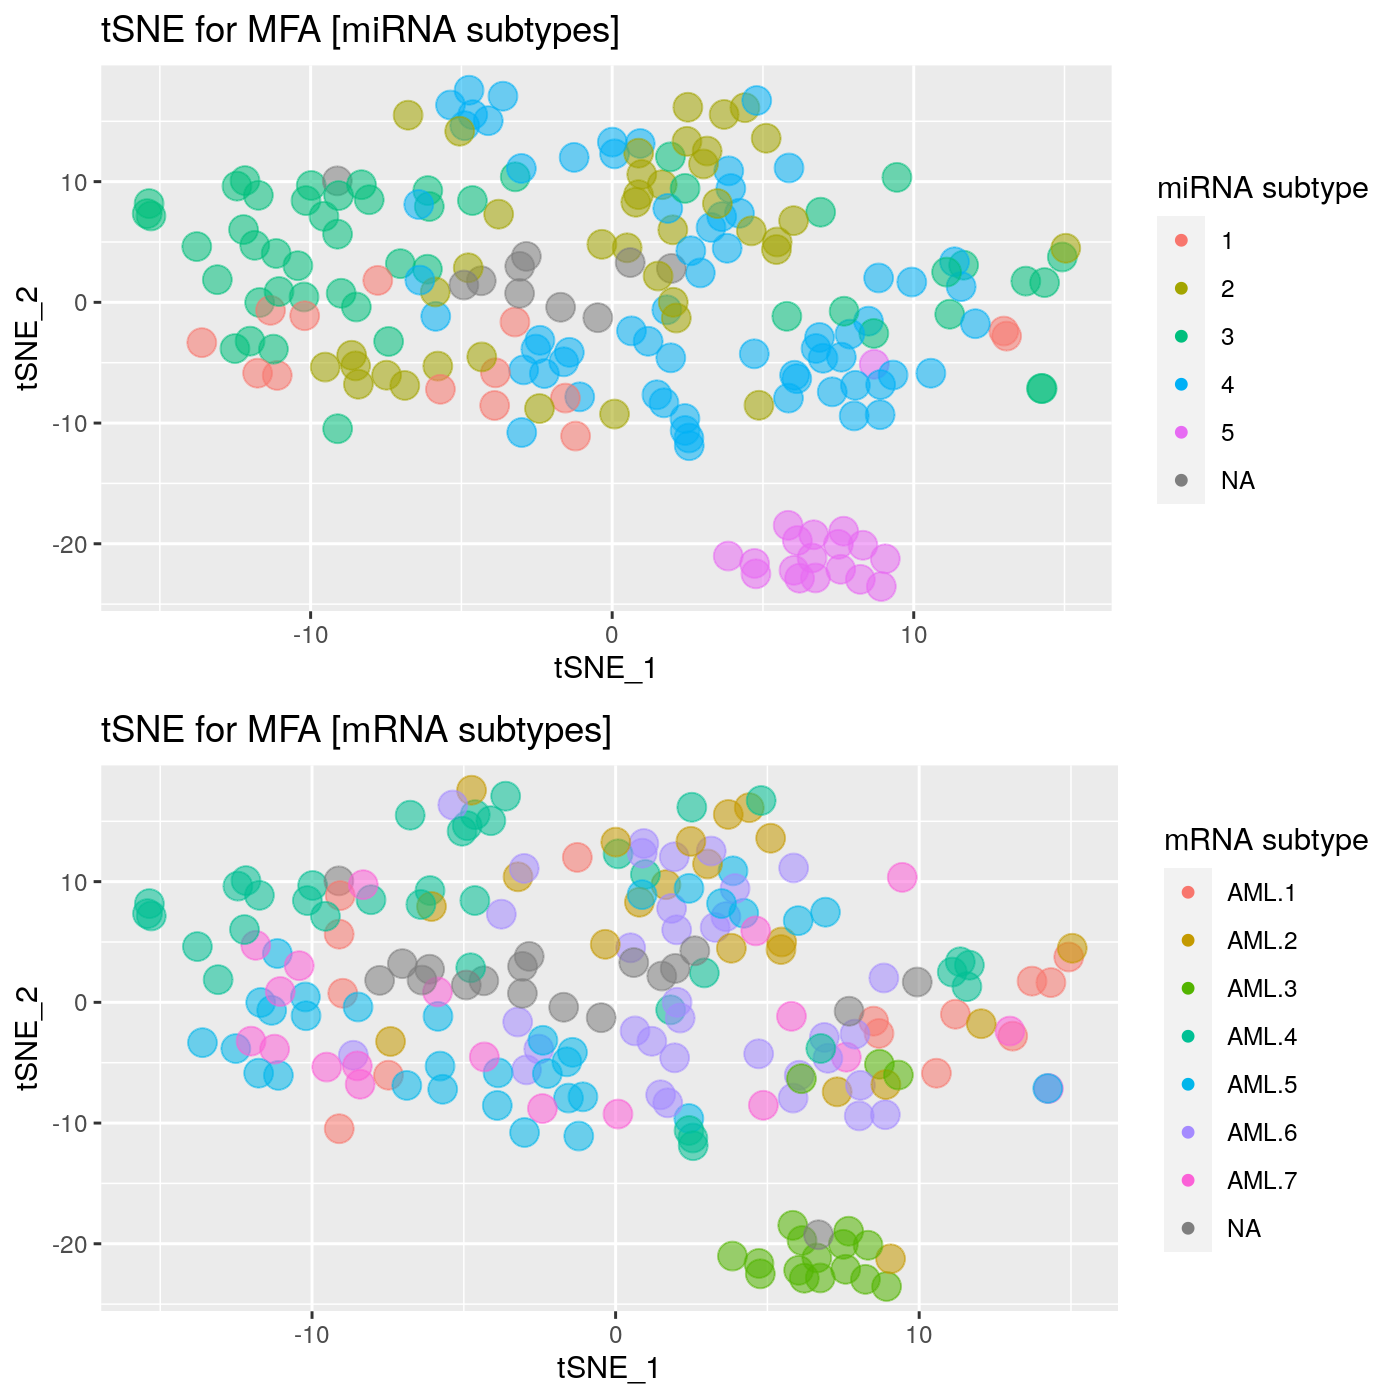

In [12]:
p1 <- mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_miRNA), size=1, alpha=0.5)) + 
    labs(title="tSNE for MFA [miRNA subtypes]", color="miRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p2 <- mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_Selected), size=1, alpha=0.5)) + 
    labs(title="tSNE for MFA [mRNA subtypes]", color="mRNA subtype") + guides(alpha=FALSE, size=FALSE) 

ggarrange(p1, p2, ncol = 1) 

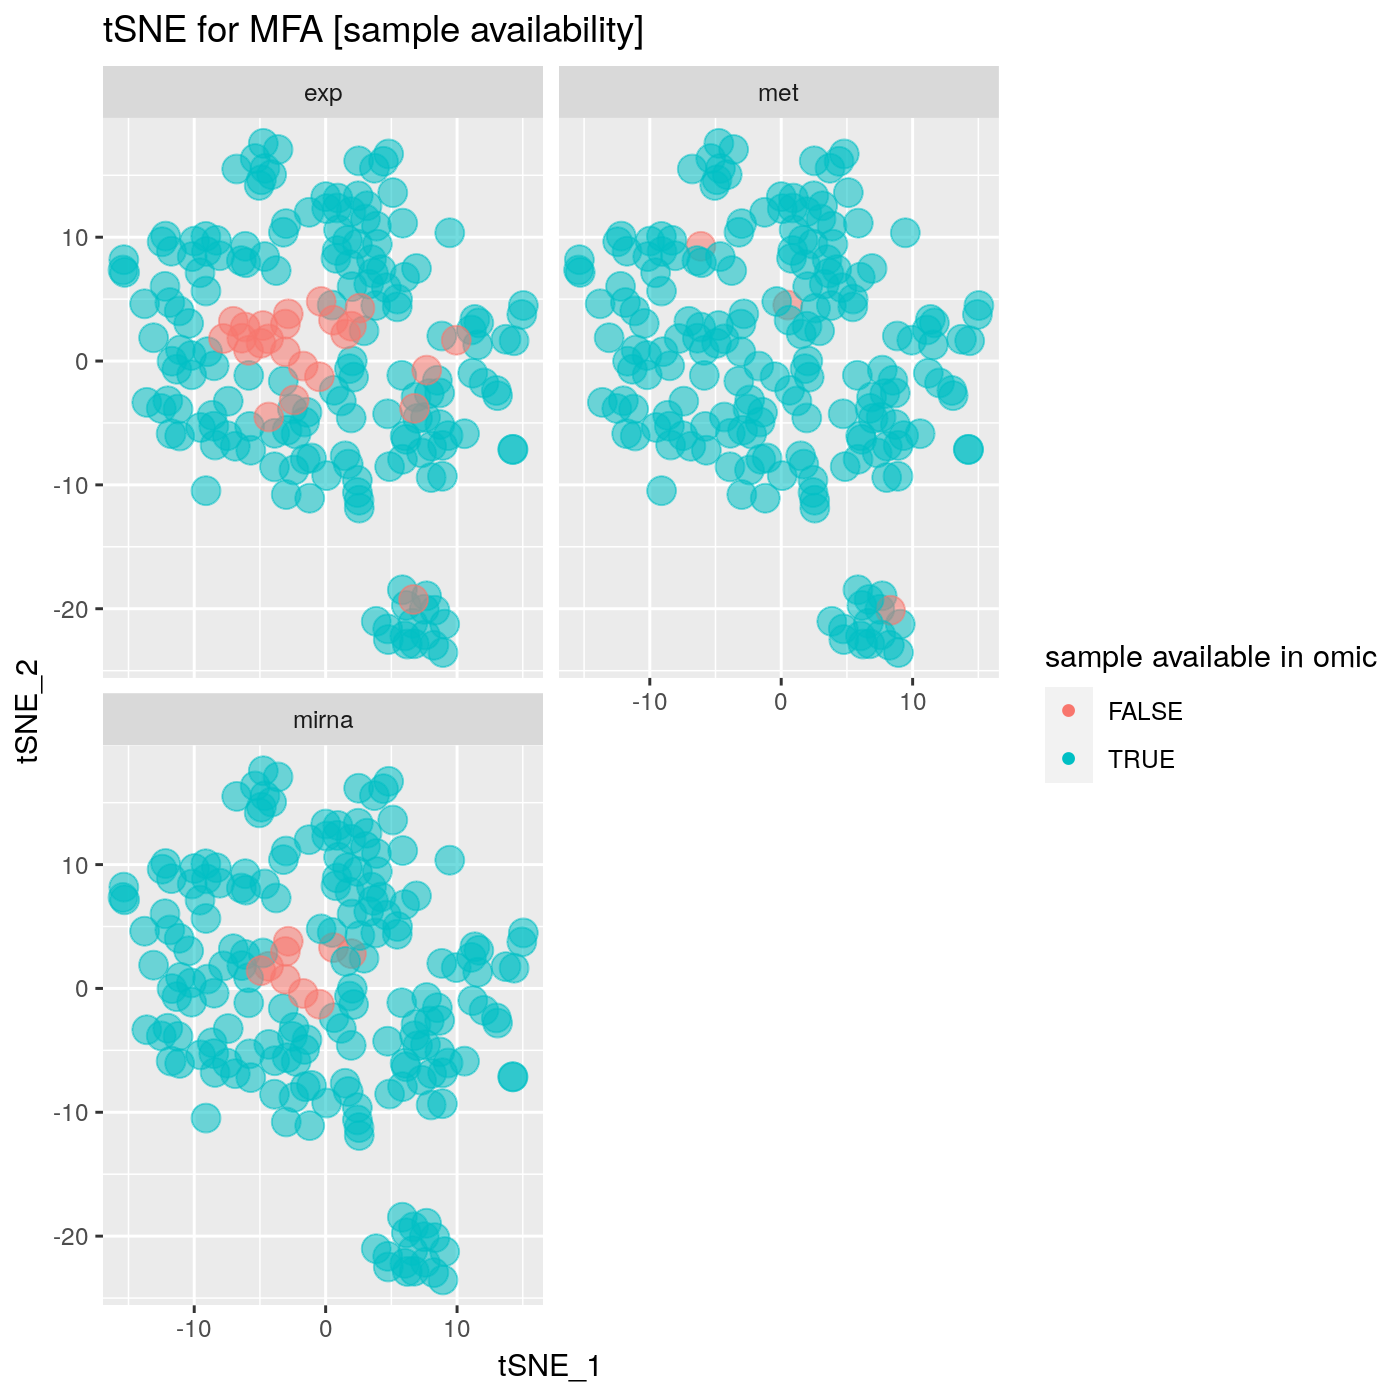

In [13]:
# let's check if our introduction of missing values (by matrix concatenation) do not drives sample separation

mfa.h.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    select(tSNE_1, tSNE_2, exp, met, mirna) %>%
    gather(omic, sample.available, -tSNE_1, -tSNE_2) %>%
    ggplot() + 
      geom_point(aes(x=tSNE_1, y=tSNE_2, color=sample.available, size=1, alpha=0.1)) + 
      facet_wrap(omic~., ncol=2) +
      labs(title="tSNE for MFA [sample availability]", color="sample available in omic") + 
      guides(alpha=FALSE, size=FALSE)


Another way to examine the MFA factors, which does not require us to do additional data transformation is a heatmap.

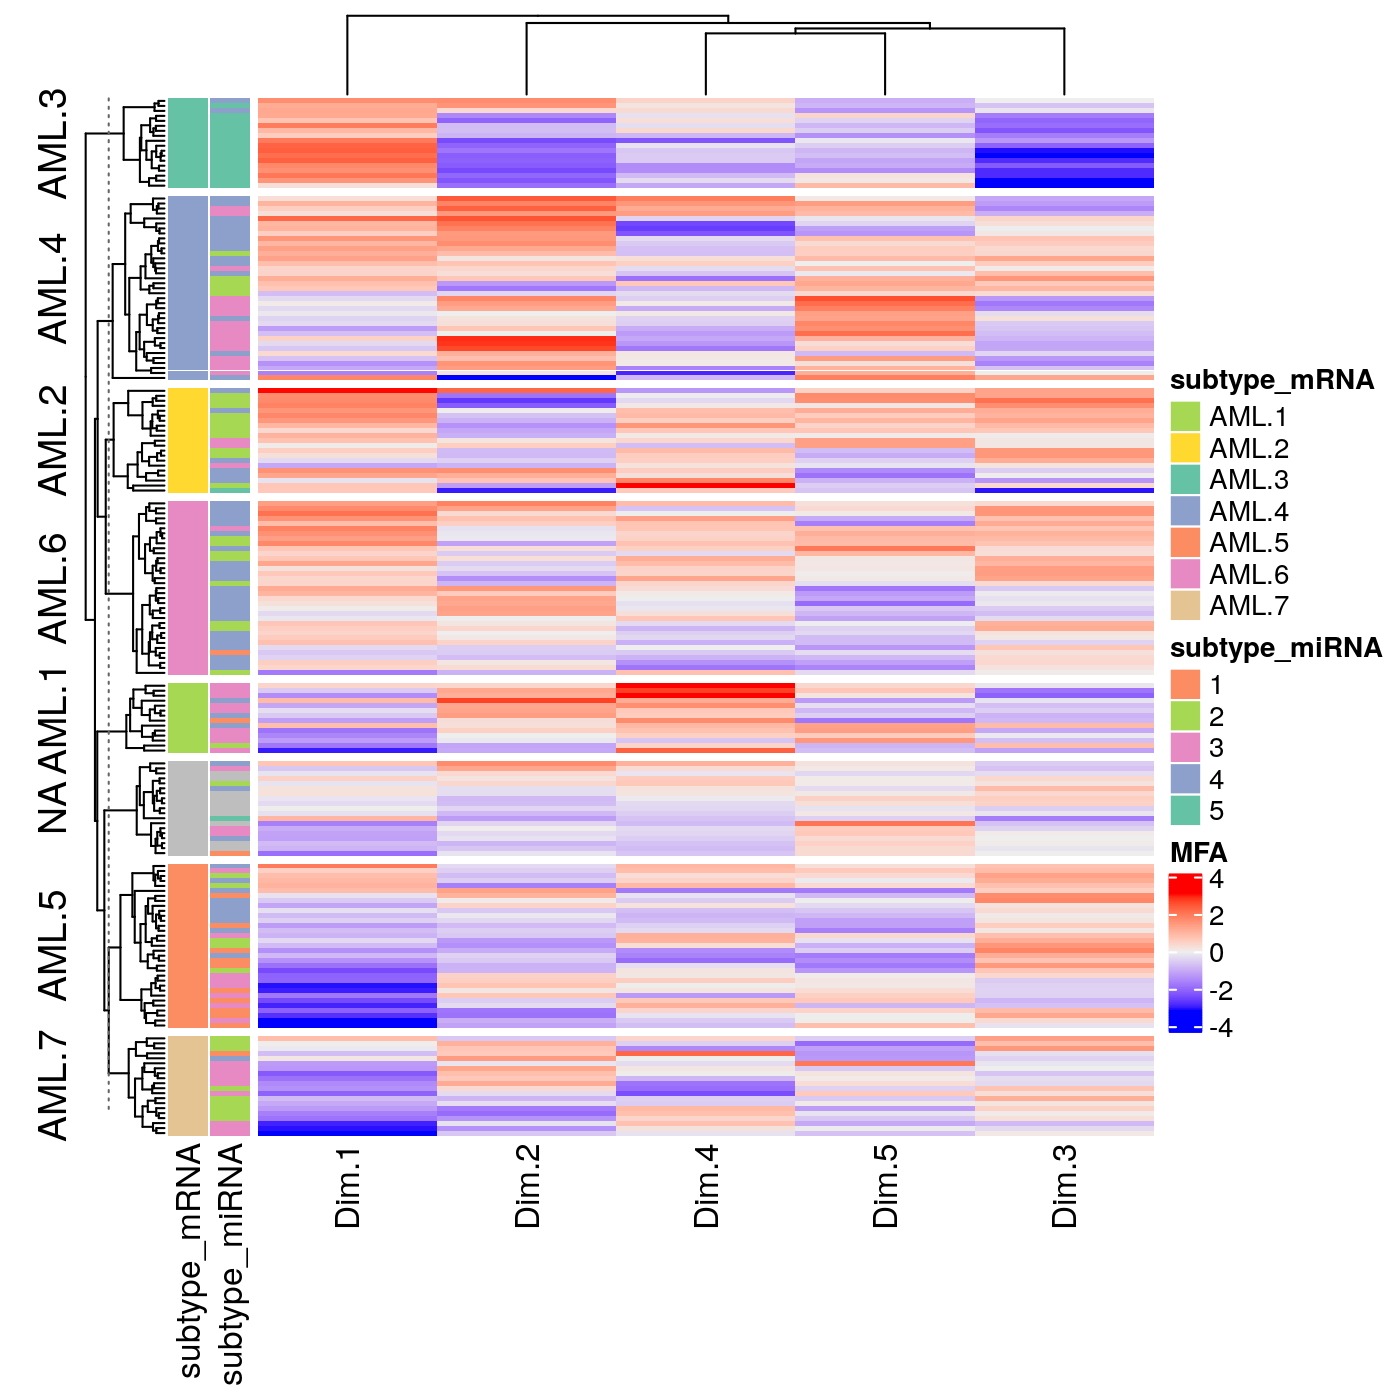

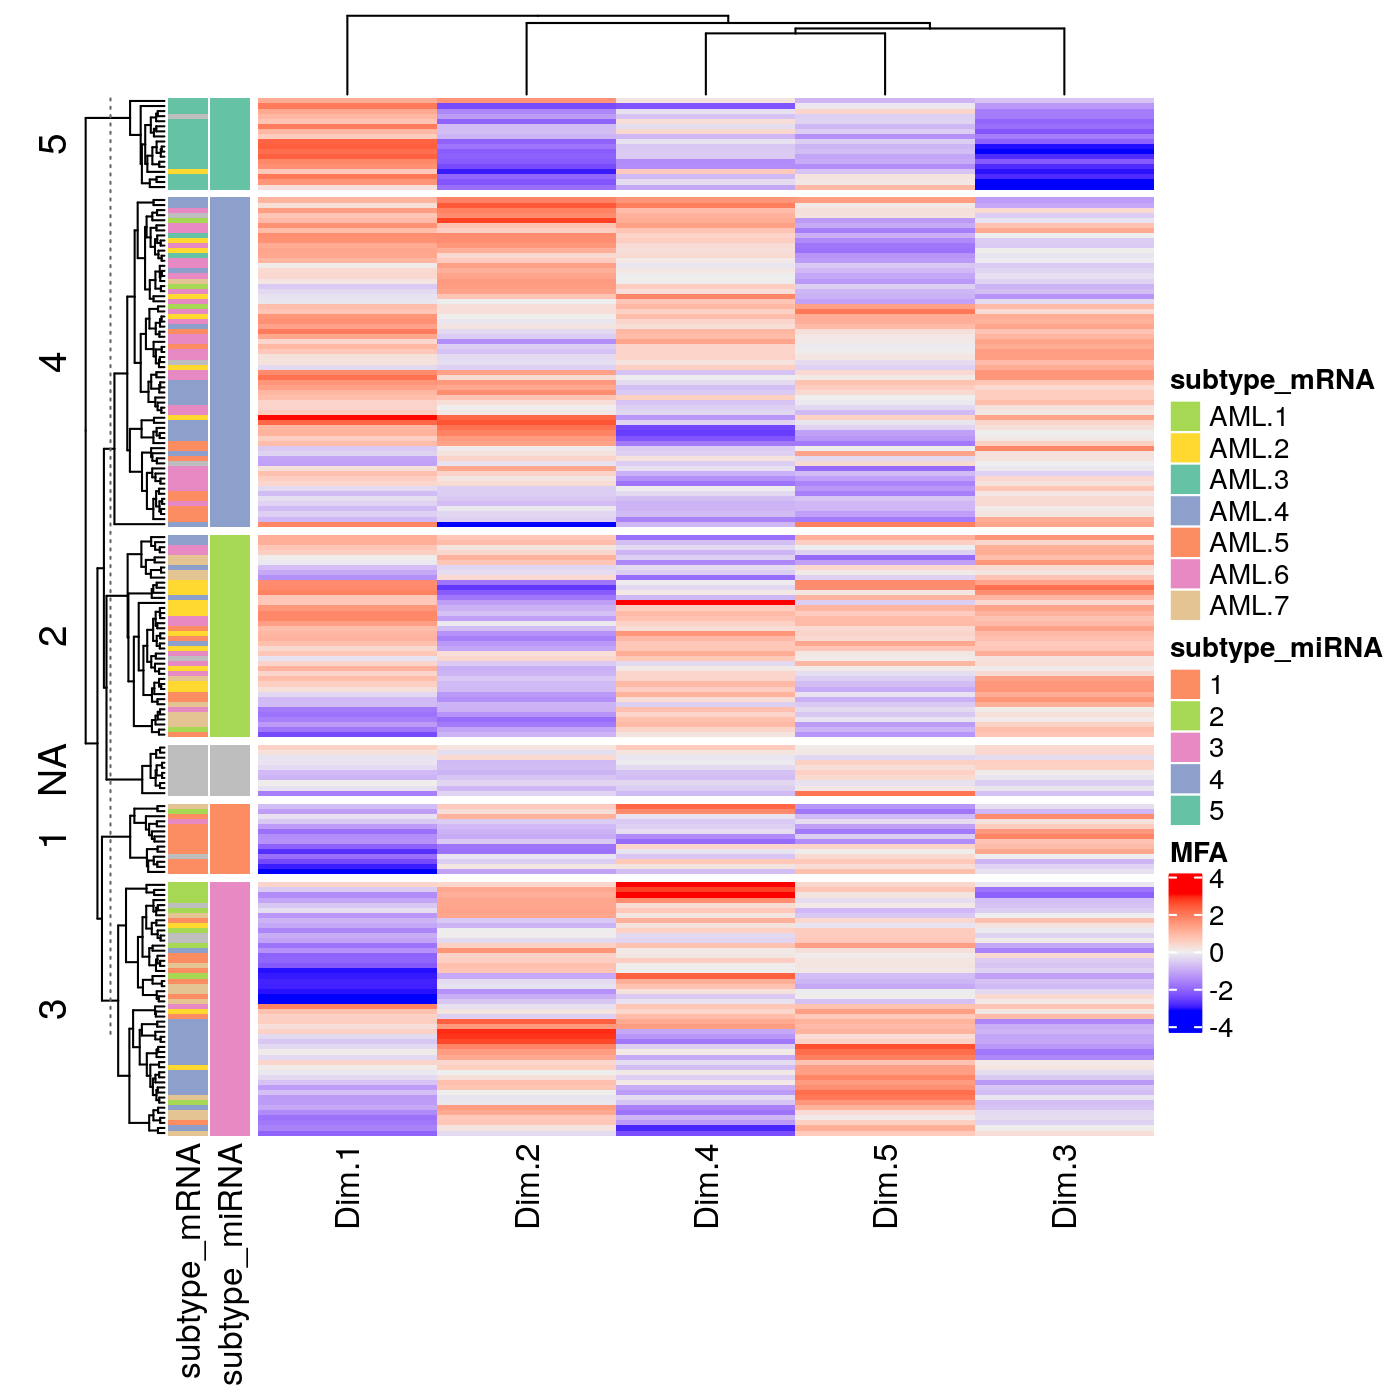

In [14]:
Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      subtype_miRNA=mfa_df$subtype_miRNA,
                                          col = list(subtype_mRNA=exp_subtypes_col, 
                                                     subtype_miRNA=miRNA_subtypes_col)),
       row_split=mfa_df$subtype_mRNA)

Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      subtype_miRNA=mfa_df$subtype_miRNA,
                                          col = list(subtype_mRNA=exp_subtypes_col, 
                                                     subtype_miRNA=miRNA_subtypes_col)),
       row_split=mfa_df$subtype_miRNA)


- As we noted during our introductory data exploration, both TCGA classifications are videly different. 
- There is group of samples (miRNA 5/ AML.3) differentiating based on both gene and miRNA expression.

### Clustering using latent factors

A common analysis in biological investigations is clustering. This is often interesting in cancer studies as one hopes to find groups of tumors (clusters) which behave similarly, i.e. have similar risks and/or respond to the same drugs. PCA is a common step in clustering analyses, and so it is easy to see how the latent variable models above may all be a useful pre-processing step before clustering. 

Here, we use K-means clustering method to invsestigate clusters in our MFA results. This method divides or partitions the data points, our working example patients, into a pre-determined, *K* number of clusters. How do we know which *K* to choose? This is a very difficult question. When visualized it is not always easy to assess the results (especially if we cannot plot them directly). Should we consider a large cluster as one cluster or should we consider the sub-clusters as individual clusters? There are some metrics to help but there is no definite answer. For biological datasets there is no "ground truth" that we can compare against. What remains is the careful assessment of range of possible *K* values using diffrent clusteing metrics. For example we may check the cluster stability (so the resistence of clusters to data perturbation) or assess the similarity between samples assigned to the same cluster (cluster silhouettes).

Moreover it is important to leverage the shortcomings of used model and biological data. Here, the clusters found (when usinh *K*=7) do not correspond to most commonly used subtypes per the TCGA metadata. However we know that the subtype assignments were created using only the gene expression, so we could expect that it could be the case. We will re-visit this subtype-cluster comparison in the further section of this tutorial.

In [36]:
# use the kmeans function to cluster the H matrix for a range of k values
mfa.clusters <- sapply(2:10, function(x) kmeans(mfa.h, x)$cluster)
colnames(mfa.clusters) <- paste0("kmeans_k", 2:10)

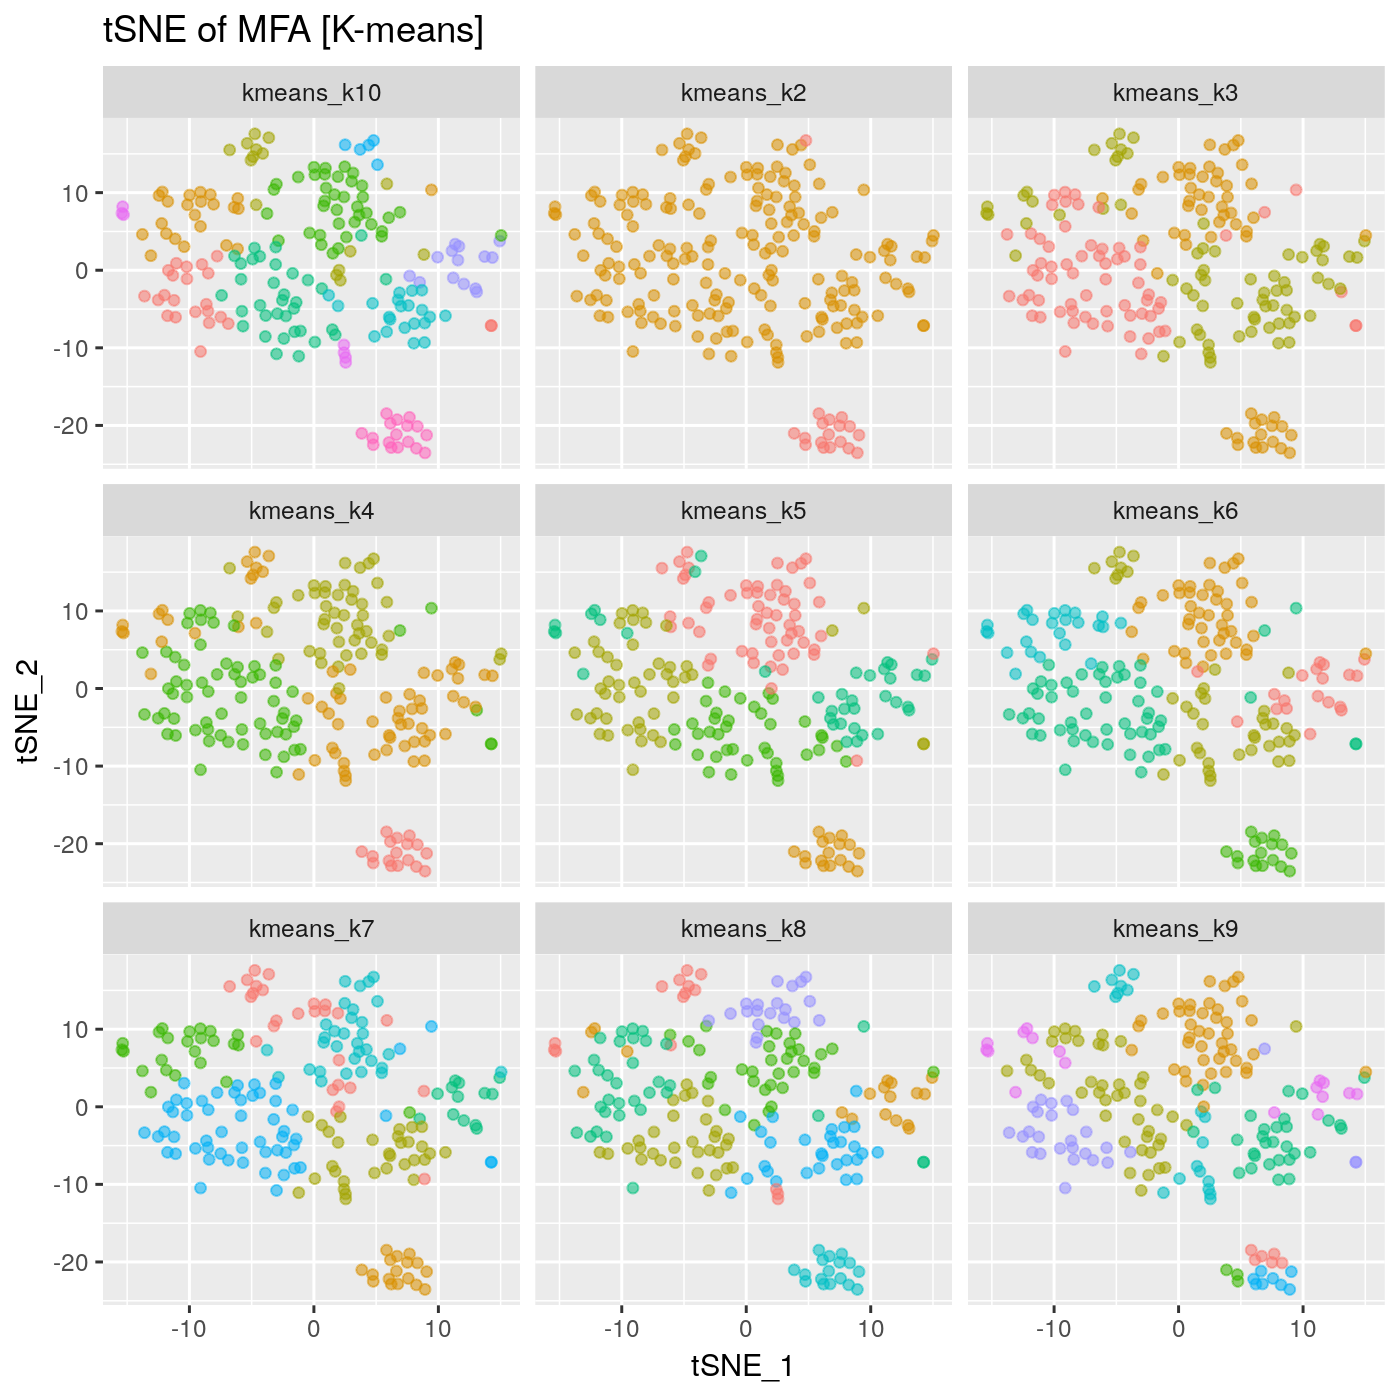

In [37]:
mfa.clusters %>%
    as_tibble() %>%
    mutate(sample_codes=rownames(mfa.clusters)) %>%
    left_join(mfa.h.tsne.tbl, by = "sample_codes") %>%
    gather(kmeans, label, -sample_codes, -tSNE_1, -tSNE_2) %>%
    mutate(label=as.factor(label)) %>%
    ggplot() +
      geom_point(aes(x=tSNE_1, y=tSNE_2, color=label, alpha=0.1)) + 
      facet_wrap(kmeans~., ncol=3) +
      labs(title="tSNE of MFA [K-means]", color="label") + 
      guides(alpha=FALSE, size=FALSE, color=FALSE)

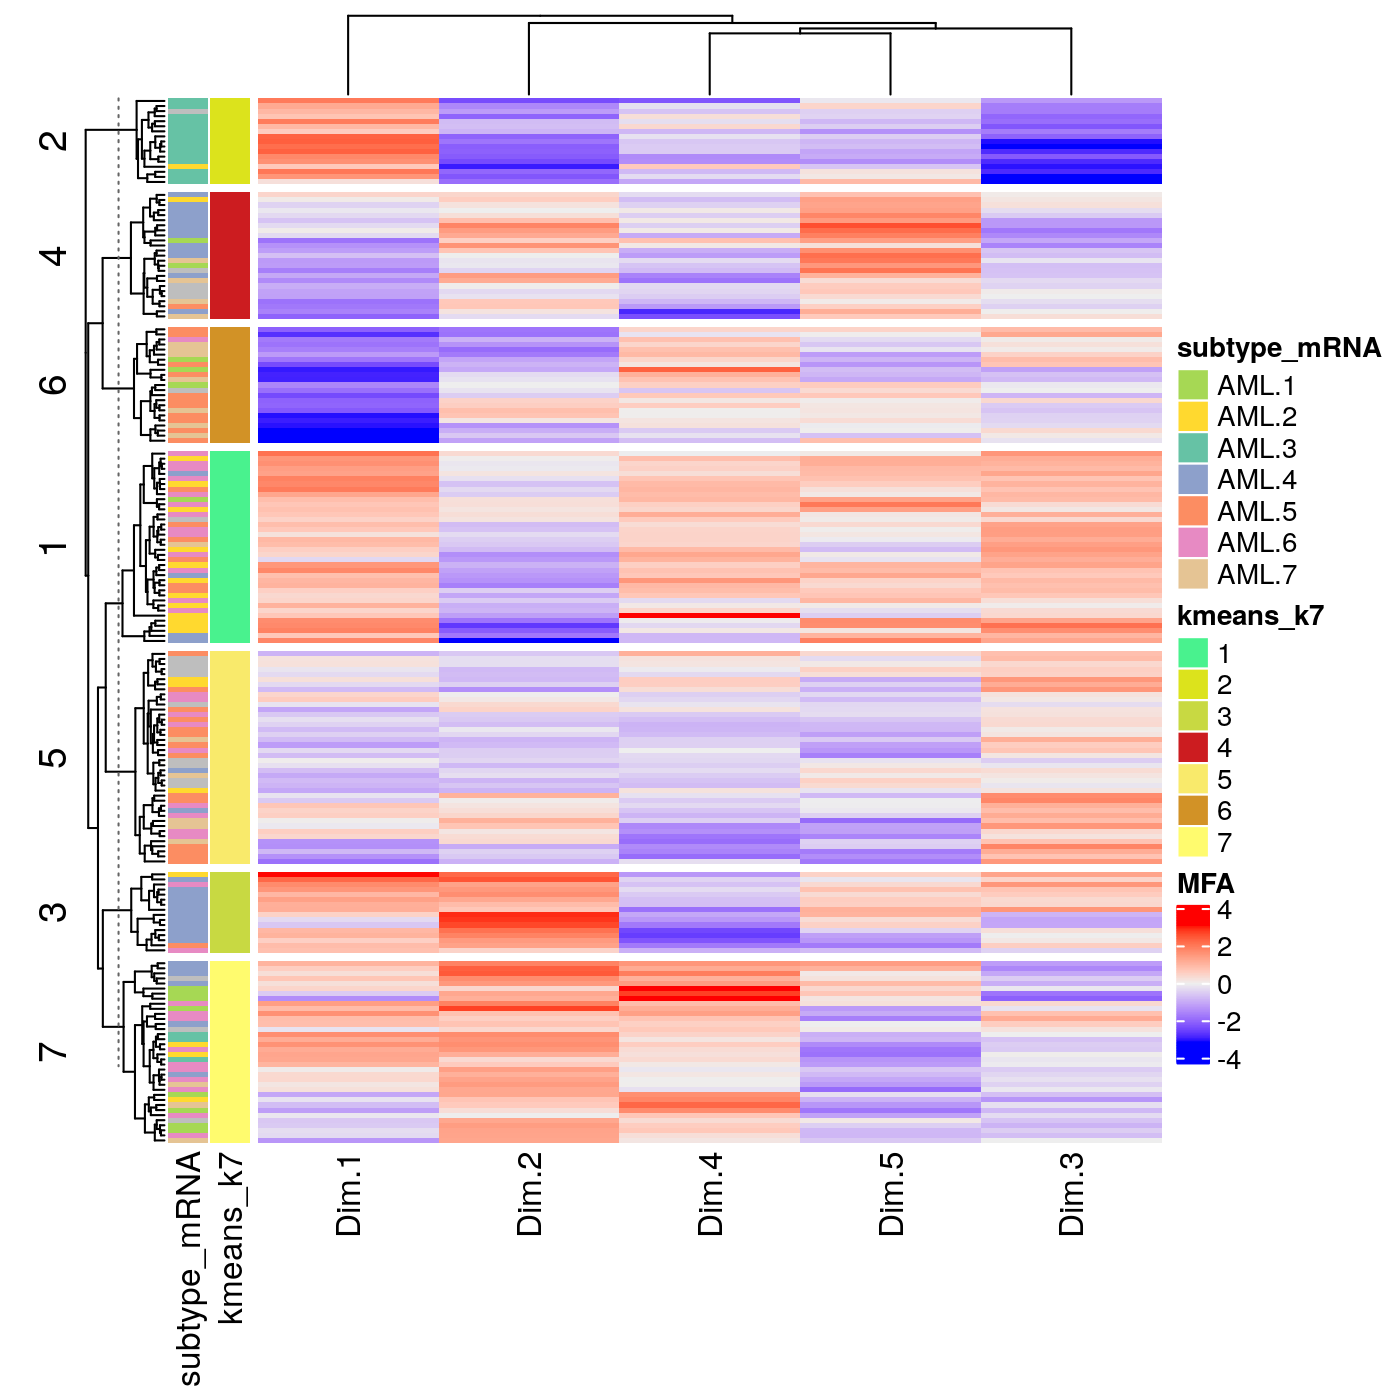

In [17]:
# comparing the Kmeans results for k=7 with TCGA subtypes
kmeans.res <- factor(mfa.clusters[, c('kmeans_k7')])
Heatmap(mfa.h, show_row_names=FALSE, name="MFA",
        left_annotation=rowAnnotation(subtype_mRNA=mfa_df$subtype_mRNA, 
                                      kmeans_k7=kmeans.res,
                                          col = list(subtype_mRNA=exp_subtypes_col)),
       row_split=kmeans.res)

## (2) iCluster & iCluster+

iCluster takes a Bayesian approach to the latent variable model. In Bayesian statistics, we infer distributions over model parameters, rather than finding a single maximum-likelihood parameter estimate. In iCluster, we model the data as: 

**X(i) = W(i)Z + ϵ_i**,

where:
- X(i) is a data matrix from a single omics platform,
- W(i) are model parameters,
- Z is a latent variable matrix shared among different omics platforms,
- ϵ_i is a normally distributed noise matrix, a random variable ϵ_i ∼ N(0,Ψ) with Ψ=diag(ψ_1,…ψ_M) a diagonal covariance matrix.

<img src="https://compgenomr.github.io/book/images/icluster.png">

With this construction, the omics measurements X(i) are expected to be similat for samples with the same latent variable representation up to Gaussian noise. iCluster maximizes the likelihood of the observed data with an additional Lasso-regularization to impose sparsity on W(i) matrices. Optimization is performed using an EM-like algorithm, briefly: the W(i) and Ψ matrices are initialized, the expected value of Z is calculated given current W(i), Ψ and X values ("E-step"), followed by maximum likelihood estimation for W(i) and Ψ values given current estimate of Z and the data X ("M-step"). The steps are repeated until the covergence of W, Ψ.


Again the "K-means" is run on the lower dimension representation of the final Z to get the final clustering assignments.

iCluster+ is an extension of the iCluster framework, which allows for omics types to arise from distributions other than a Gaussian. While normal distributions are a good assumption for log-transformed, centered gene expression data, it is a poor model for binary mutations data, or copy number variation data. iCluster+ allows the different X(i) to have different distributions:
- for binary mutations, X is drawn from a multivariate binomial
- for normal, continuous data, X is drawn from a multivariate Gaussian 
- for copy number variations, X is drawn from a multinomial
- for count data, X is drawn from a Poisson.

iCluster+ fits a regularized latent variable model based clustering that generates an integrated cluster assignment based on joint Bayesian inference across data types.

iCluster+ remains one of the most popular mulit-omic integration method, however it is important to note that it supports only the integration of data matrices with equal number of samples and no missing values. Here, we subset our dataset and use only the samples common for all our data types. Moreover the execution time of iCluster+ is deffinetly worth consideration. For the datasets with high number of features, additional feature selection step may be required.

In [42]:
common_samples <- subtypes_data %>% filter(exp & met & mirna) %>% pull(sample_codes)
exp.common <- data_exp[, common_samples]
met.common <- data_met[, common_samples]
mirna.common <- data_mirna[, common_samples]

In [44]:
# run the iClusterPlus function on common samples data set (this will take a couple of minutes)
r.icluster <- iClusterPlus(
  t(exp.common), # Providing each omics type
  t(met.common),
  t(mirna.common),
  type=rep("gaussian", 3), # Providing the distributions
  K=6, # provide the number of factors to learn (number of clusters is k+1)
  alpha=c(1,1,1), # as well as other model parameters
  lambda=c(.03,.03,.03))

How do we decide on model parameters? Usually, we would like to use the parallel computing (and "tune.iClusterPlus" function) to search throught the parameter space to look for the best model. The number of point to sample (n.lambda) depends on the number of data.types - see the [iCluster+ user manual](https://www.mskcc.org/sites/default/files/node/18547/documents/iclusterplususerguide_0.pdf) for more details.
This step is very time consuming so we omit it in this tutorial.

In [21]:
# extract the H and W matrices from the run result
# here, we refer to H as z, to keep with iCluster terminology
icluster.z <- r.icluster$meanZ
rownames(icluster.z) <- colnames(exp.common) # fix the row names
icluster.ws <- r.icluster$beta

In [22]:
# We run tSNE to visually inspect sample separation by existing subtypes
icp.tsne <- tsne(icluster.z)
icp.tsne.tbl <- as_tibble(icp.tsne) %>%
    rename(tSNE_1=V1, tSNE_2=V2) %>%
    mutate(sample_codes = colnames(exp.common))

sigma summary: Min. : 0.471932899046001 |1st Qu. : 0.562763550472876 |Median : 0.601097977936462 |Mean : 0.600615309857752 |3rd Qu. : 0.63749100121893 |Max. : 0.732129659784517 |

Epoch: Iteration #100 error is: 15.0766796873605

Epoch: Iteration #200 error is: 0.787931271542624

Epoch: Iteration #300 error is: 0.726827134257301

Epoch: Iteration #400 error is: 0.654141817604704

Epoch: Iteration #500 error is: 0.650038802337937

Epoch: Iteration #600 error is: 0.650037821425439

Epoch: Iteration #700 error is: 0.650037756896092

Epoch: Iteration #800 error is: 0.650037752277121

Epoch: Iteration #900 error is: 0.650037751888619

Epoch: Iteration #1000 error is: 0.650037751857725



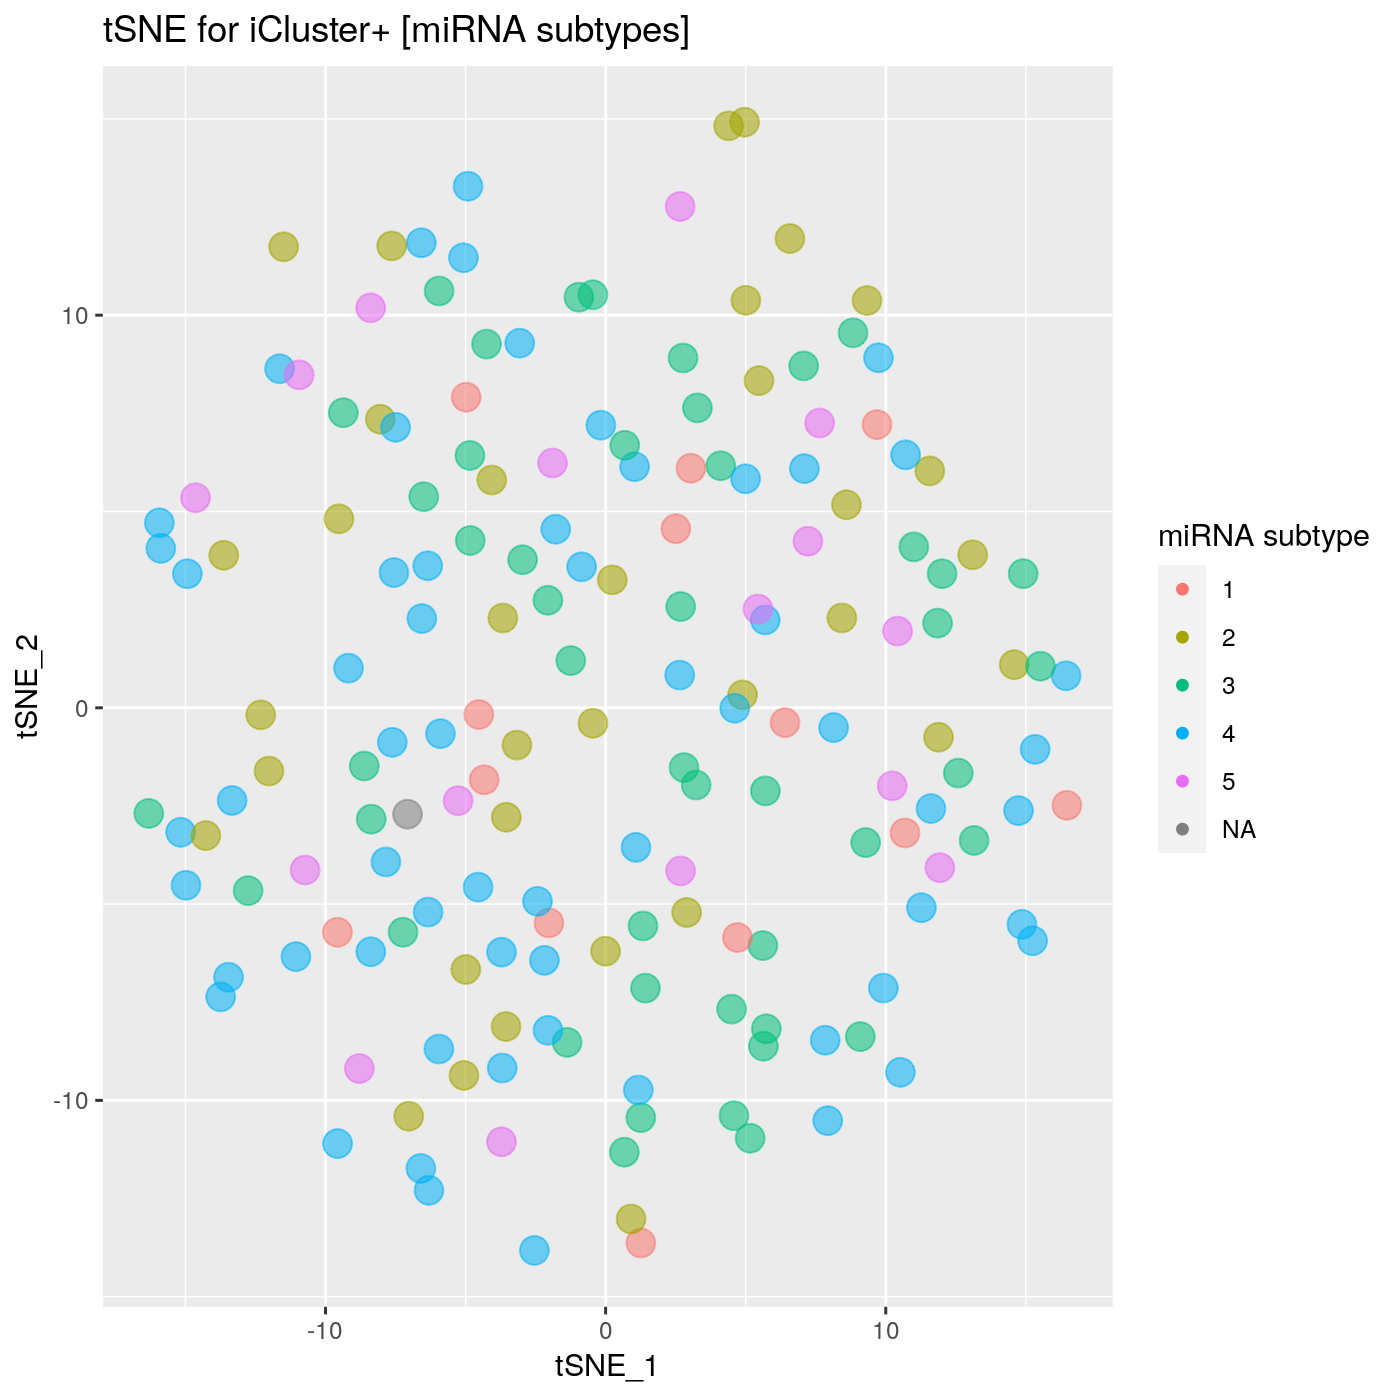

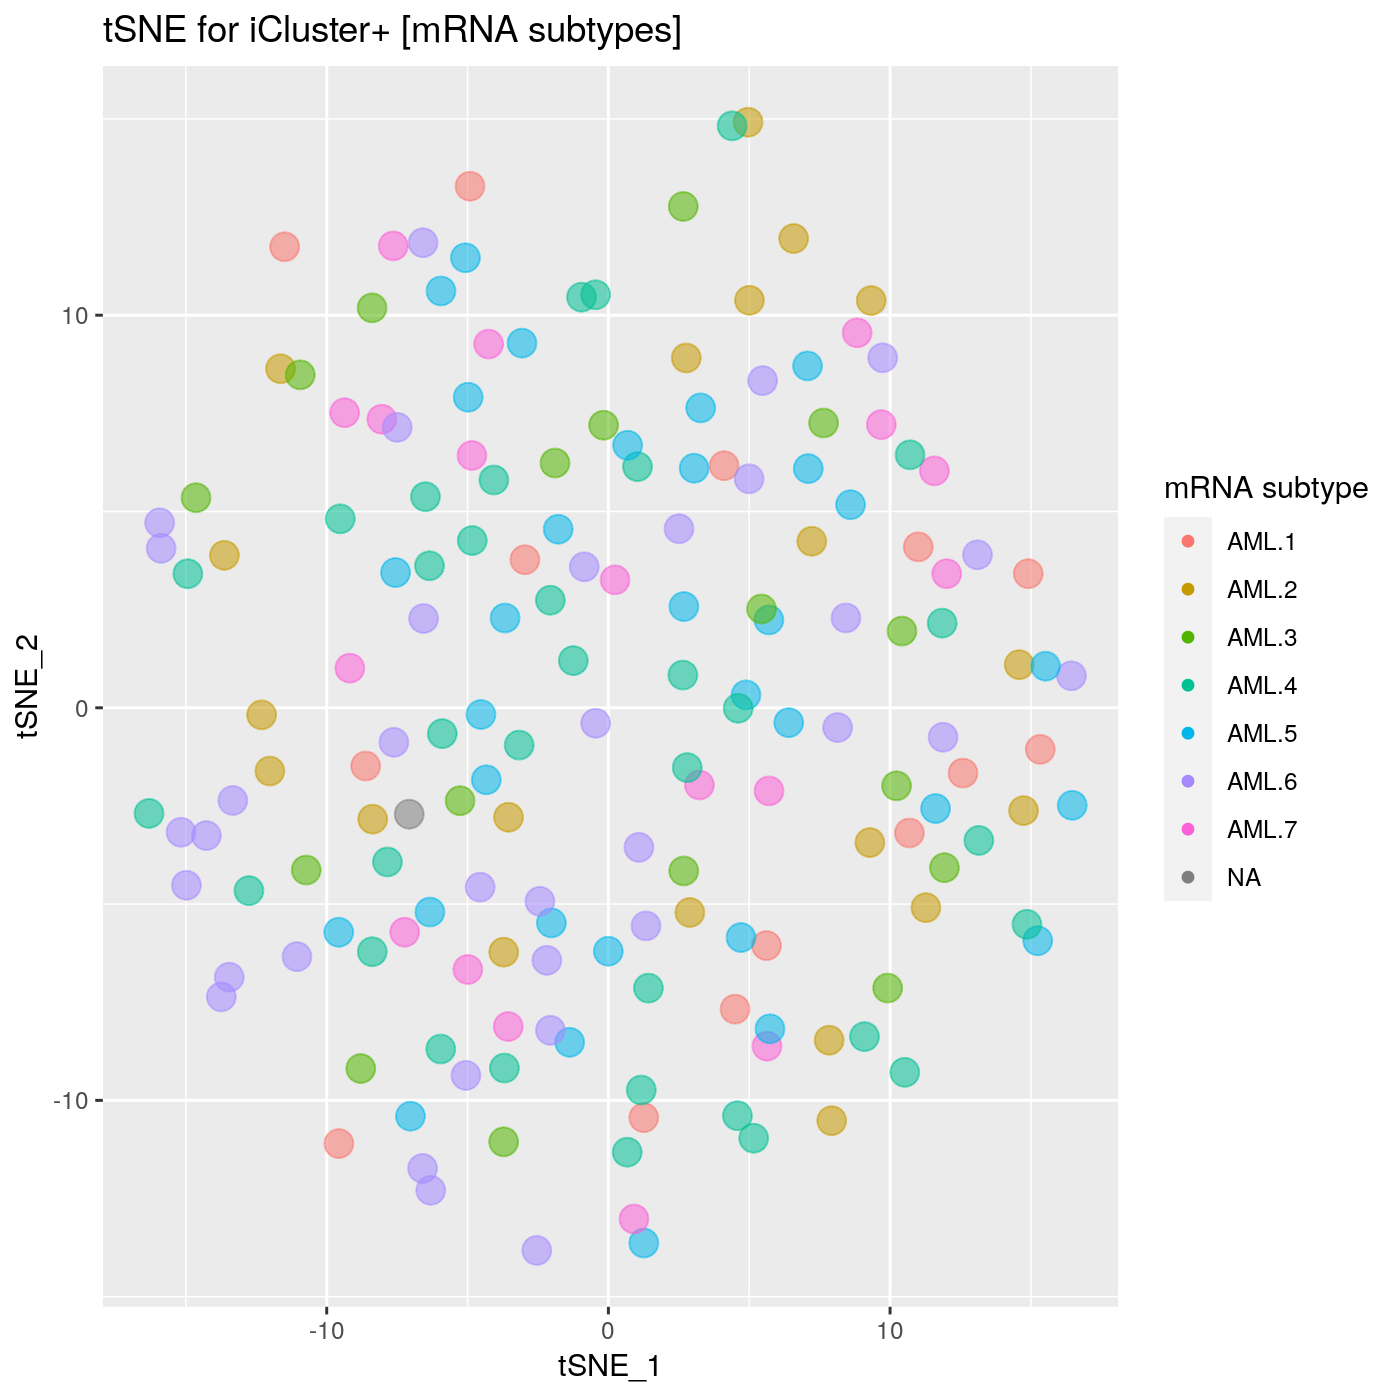

In [29]:
p1 <- icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_miRNA), size=1, alpha=0.5)) + 
    labs(title="tSNE for iCluster+ [miRNA subtypes]", color="miRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p2 <- icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
     ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(Subtype_Selected), size=1, alpha=0.5)) + 
     labs(title="tSNE for iCluster+ [mRNA subtypes]", color="mRNA subtype") + guides(alpha=FALSE, size=FALSE) 

p1
p2

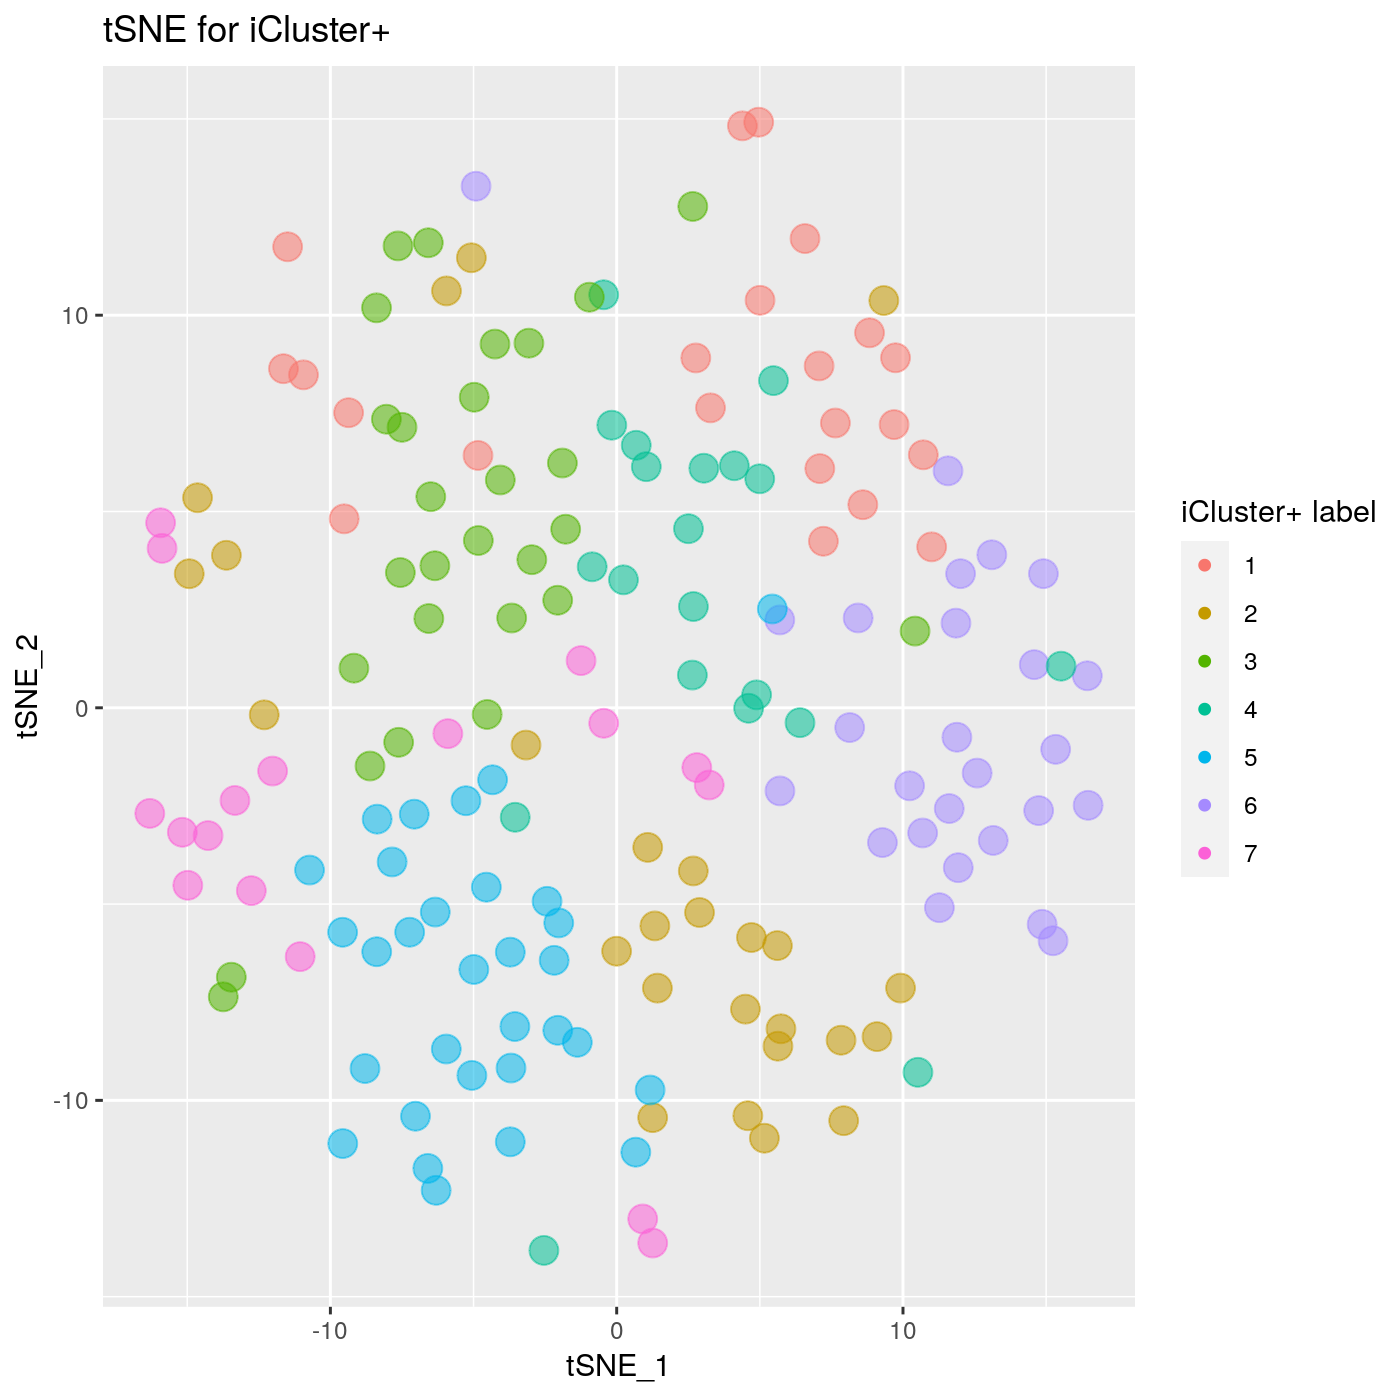

In [24]:
icp.tsne.tbl %>%
    left_join(subtypes_data, by = "sample_codes") %>%
    mutate(icp_label=r.icluster$clusters) %>%
    ggplot() + geom_point(aes(x=tSNE_1, y=tSNE_2, color=as.factor(icp_label), size=1, alpha=0.5)) + 
     labs(title="tSNE for iCluster+", color="iCluster+ label") + guides(alpha=FALSE, size=FALSE) 


## (3) PINS & PINS+

PINS is an example of late integration mulit-omic framework. This method works by the integration of **co-clustering patterns in separate omics**. The patterns are based on the assasement of cluster robustness to the perturbation of original data.

PINS clusters each data type separately and creates a **connectivity matrix** *S_i (n x n)*, where *n* is the number of samples. The *S_i(xy) = 1* if two samples are clustered together and *0* otherwise. The original data is then perturbed multiple times by the addition of Gaussian noise. Resulted connectivity matrices are then used to create a similarity matrix, by assessing the average pair-wise connectivity between the samples.
In the ideal case the similarity matrix defines groups of patients that are strongly connected across all of that data types. However, as we observed previously in practise it may not be the case. In this case the average connectivity value is used to create the similarity matrix. Finally the similarity matrix is partitioned to find sample labels. To assess if data follows hierarchical structure the connectivity assassment is repeated separately for sample groups identified in first stage, so samples can be split into subgroups if it's possible.

PINS+ is an extension of PINS that greatly improve the efficacy of the method. PINS+ require each data type to have the same number of samples, and no missing values in feature matrices.

In [60]:
pins.ret = PINSPlus::SubtypingOmicsData(dataList=list(t(exp.common), t(met.common), t(mirna.common)), 
                                        kMax = 9,
                                        ncore = 2) #number of cores for parallel computing

Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 10.0913798809052 secs.


Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 8.98048281669617 secs.


Clustering method: kmeans

Perturbation method: noise

Building original connectivity matrices



  |======================================================================| 100%


Building perturbed connectivity matrices



  |======================================================================| 100%


Done in 17.301198720932 secs.


STAGE : 1	 Agreement : 0.301287852419074

Check if can proceed to stage II

Done in 36.7540643215179 secs.




In [62]:
clustering2 = pins.ret$cluster2
clustering1 = pins.ret$cluster1

## (4) SUMO

SUMO is a novel method mulit-omic integration method that combines the omic-specific similarity driven approaches with the joint dimensionality reduction framework. 

First each omic is inspected separately and the pairwise distances between samples are calculated.

<img src="sumo_workflow.png">

In [ ]:
### SUMO

# consensus clustering

save expression -> data pre-processing
methylation M values to beta values ??

sumo prepare
sumo run k = 7
plot consensus matrix with labels

In [ ]:
### Interpretation of results 
# surivival + clinical analysis
# - feature weights of loading vectors
# gene enrichement analysis and feature loading assassement